#### Coordinate Reprojections for EUMETSAT/MSG Data

In [1]:
import autoroot

In [2]:
import os
import ast
import eumdac
import datetime
import shutil
import pyproj
import rioxarray
import rasterio
import xarray as xr

from pyproj import CRS

In [3]:
%load_ext autoreload
%autoreload 2

Unfortunately, .nat files are a bit complicated to read/load. One of the best packages is satpy, which then allows loading the files using xarray.

In [4]:
from satpy import Scene
scn = Scene(reader="seviri_l1b_native", filenames=['MSG4-SEVI-MSG15-0100-NA-20211110081242.766000000Z-NA.nat'])

In [5]:
# MSG data contains 12 channels, including the high-resolution visible (HRV) channel.
datasets = scn.available_dataset_names()
datasets

['HRV',
 'IR_016',
 'IR_039',
 'IR_087',
 'IR_097',
 'IR_108',
 'IR_120',
 'IR_134',
 'VIS006',
 'VIS008',
 'WV_062',
 'WV_073']

In order to convert the scn object to xarray, each dataset needs to be loaded.

In [6]:
scn.load(datasets[1:], generate=False)
# Note: The HRV channel comes in 1 km resolution, while the other channels are 3 km resolution.
# Because of the size mismatch, the HRV channel would either need to be downscaled,
# or it needs to the loaded separetely to the other channels


/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))
/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/xarray/core/concat.py:544: FutureWarning

In [7]:
ds = scn.to_xarray()

/opt/anaconda3/envs/iti-env/lib/python3.11/site-packages/satpy/cf/coords.py:201: UserWarning: Cannot pretty-format "acq_time" coordinates because they are not identical among the given datasets
  _warn_if_pretty_but_not_unique(pretty, coord_name)


In [15]:
# The x and y coordinate contain spatial information in meters
ds

<xarray.Dataset>
Dimensions:             (y: 3712, x: 3712)
Coordinates: (12/15)
    IR_016_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
  * y                   (y) float64 -5.566e+06 -5.563e+06 ... 5.569e+06
  * x                   (x) float64 5.566e+06 5.563e+06 ... -5.569e+06
    longitude           (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    latitude            (y, x) float64 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    ...                  ...
    IR_120_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    IR_134_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS006_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    VIS008_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_062_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
    WV_073_acq_time     (y) datetime64[ns] NaT NaT NaT NaT ... NaT NaT NaT NaT
Data variables:
    msg_seviri_fes_3km  int64 0
    IR_016              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_039              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_087              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_097              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_108              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_120              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    IR_134              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS006              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    VIS008              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_062              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
    WV_073              (y, x) float32 dask.array<chunksize=(928, 3712), meta=np.ndarray>
Attributes:
    history:      Created by pytroll/satpy on 2024-03-21 14:51:49.728185
    Conventions:  CF-1.7

In [9]:
ds.latitude.values

array([[inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       ...,
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf],
       [inf, inf, inf, ..., inf, inf, inf]])

In [10]:
# That's why we need to extract the satellite position, to convert the x and y coordinates to lat/lon
pa = ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])['projection_altitude']
saa = ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])['satellite_actual_altitude']

ast.literal_eval(ds['IR_016'].attrs['orbital_parameters'])

{'projection_longitude': 0.0,
 'projection_latitude': 0.0,
 'projection_altitude': 35785831.0,
 'satellite_nominal_longitude': 0.0,
 'satellite_nominal_latitude': 0.0,
 'satellite_actual_longitude': -0.3394201003380397,
 'satellite_actual_latitude': 0.3537999733591259,
 'satellite_actual_altitude': 35783787.81506324}

In [36]:
# Testing for one channel
dataset = scn['IR_016']

dataset

<xarray.DataArray 'reshape-cac76ceb052e05475f9c446cef4093e1' (y: 3712, x: 3712)>
dask.array<mul, shape=(3712, 3712), dtype=float32, chunksize=(928, 3712), chunktype=numpy.ndarray>
Coordinates:
    acq_time  (y) datetime64[ns] NaT NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs       object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknown",...
  * y         (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x         (x) float64 5.566e+06 5.563e+06 5.56e+06 ... -5.566e+06 -5.569e+06
Attributes: (12/20)
    orbital_parameters:                     {'projection_longitude': 0.0, 'pr...
    sun_earth_distance_correction_applied:  True
    sun_earth_distance_correction_factor:   0.9901881739103313
    units:                                  %
    wavelength:                             1.64 µm (1.5-1.78 µm)
    standard_name:                          toa_bidirectional_reflectance
    ...                                     ...
    name:                                   IR_016
    resolution:                             3000.403165817
    calibration:                            reflectance
    modifiers:                              ()
    _satpy_id:                              DataID(name='IR_016', wavelength=...
    ancillary_variables:                    []

In [38]:
dataset_example = list(ds.data_vars)[0]
dataset_example

'msg_seviri_fes_3km'

In [40]:
# crs_wkt = ds[dataset_example].crs_wkt

# # Define the source CRS from the WKT string
# source_crs = pyproj.CRS(crs_wkt)
# target_crs = 'EPSG:4326' # Global lat-lon coordinate system

In [33]:
crs_wkt = dataset.attrs['area'].crs_wkt

# Define the source CRS from the WKT string
source_crs = pyproj.CRS(crs_wkt)
target_crs = 'EPSG:4326' # Global lat-lon coordinate system

In [50]:
# copy dataset
new_dataset = dataset.copy(deep=True)

# assign CRS to dataarray
new_dataset = new_dataset.rio.write_crs(source_crs, inplace=False)

In [51]:
print(new_dataset.dims)
print(new_dataset.coords)

new_dataset = new_dataset.drop('acq_time') # Drop acq_time coordinate, which was causing issues # NOTE: Not sure why this is necessary?
# new_dataset = new_dataset.drop('latitude') # NOTE: Not sure why this is necessary?
# new_dataset = new_dataset.drop('longitude') # NOTE: Not sure why this is necessary?
# Reproject the data to the target CRS
new_dataset = new_dataset.rio.reproject(target_crs)

('y', 'x')
Coordinates:
    acq_time     (y) datetime64[ns] NaT NaT NaT NaT NaT ... NaT NaT NaT NaT NaT
    crs          object PROJCRS["unknown",BASEGEOGCRS["unknown",DATUM["unknow...
  * y            (y) float64 -5.566e+06 -5.563e+06 ... 5.566e+06 5.569e+06
  * x            (x) float64 5.566e+06 5.563e+06 ... -5.566e+06 -5.569e+06
    spatial_ref  int64 0


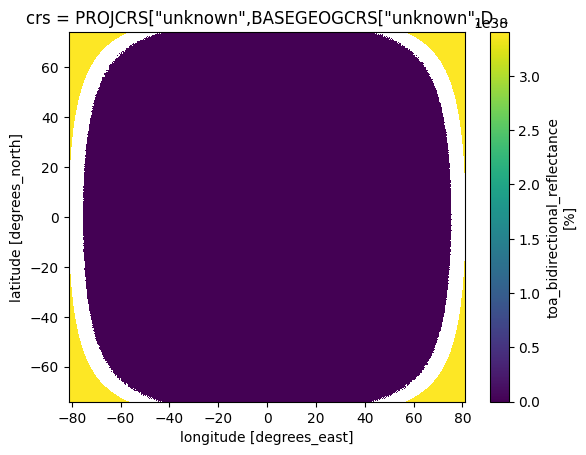

In [52]:
new_dataset.plot()
# Something strange is happening to the data? All values are set to XE38, which is not correct.

In [107]:
# Assign latitude/longitude coordinates to original data
dataset['latitude'] = new_dataset.x
dataset['longitude'] = new_dataset.y

TODO:

- Finish reprojection function. Currently a few problems: 
    - pyproj modifies the data
    - the shape of the new x/y is not the same as before